## Seq2Seq Neural Machine Translation Model

A tensorflow version of a basic seq2seq model for machine transklation with the NLP preprocessing.

tesorflow-gpu=1.12.0

GPU: 1080

### preprocessing & data loading

Here, we use the NLP preprocess tricks taught in class to clean the input data for better training. First, we load the data as a really long string to later create a lookup table for embedding. Then, we split the data into sentences and pass them to the preprocessing function and then concate together to get the clean data for both source(English) and target(French) language.

In [27]:
import tensorflow as tf
import numpy as np
from collections import Counter
import os, copy, pickle, re
import matplotlib.pyplot as plt 

def preprocess(text):
    
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Remove emotion signature and Capitalization
    emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)  
    text = re.sub('[\W|\.]+', ' ', text.lower())+' '.join(emotions).replace('-', '')
        
    return text

def load_data(source_path, target_path):
    
    source_input_file = os.path.join(source_path)
    source_clean_data = []
    
    target_input_file = os.path.join(target_path)
    target_clean_data = []
    
    with open(source_input_file, 'r', encoding='utf-8') as f:
        source_data = f.read()
    
    with open(target_input_file, 'r', encoding='utf-8') as f:
        target_data = f.read()
    
    source_sentences = source_data.split("\n")
    target_sentences = target_data.split("\n")

    for i in range(len(source_sentences)):
        source_clean_data.append(preprocess(source_sentences[i]) + '\n')
        target_clean_data.append(preprocess(target_sentences[i]) + '\n')

    source_clean_data = " ".join(source_clean_data)
    target_clean_data = " ".join(target_clean_data)

    return source_clean_data, target_clean_data

### create lookup table

For general NLP task, we not only need a lookup table for mapping vocabulary into numbers for training and inference but also need it to mapping the model output back into required vacabulary to check the model performance and application. Here, we create a lookup table for both cleanup source and target corpus with all the vacabulary in he corpus and also the special token for modle to recongnize the *padding*, *end of sentence*, *unknown*(out of vacabulary), *go*(for model start encoding and decoding).

In [10]:
def create_lookup_tables(text):
    CODES = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3 }

    vocab = set(text.split())
    vocab_to_int = copy.copy(CODES)

    for v_i, v in enumerate(vocab, len(CODES)):
        vocab_to_int[v] = v_i

    int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab

### mapping the corpus into numbers

with the lookup table, here we map the sentence into integers for the model.

In [11]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):

    source_text_id = []
    target_text_id = []
    
    # make a list of sentences (extraction)
    source_sentences = source_text.split("\n")
    target_sentences = target_text.split("\n")
        
    max_source_sentence_length = max([len(sentence.split(" ")) for sentence in source_sentences])
    max_target_sentence_length = max([len(sentence.split(" ")) for sentence in target_sentences])
        
    # iterating through each sentences (# of sentences in source&target is the same)
    for i in range(len(source_sentences)):
        # extract sentences one by one
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        
        # make a list of tokens/words (extraction) from the chosen sentence
        source_tokens = source_sentence.split(" ")
        target_tokens = target_sentence.split(" ")
        
        # empty list of converted words to index in the chosen sentence
        source_token_id = []
        target_token_id = []
        
        for index, token in enumerate(source_tokens):
            if (token != ""):
                source_token_id.append(source_vocab_to_int[token])
        
        for index, token in enumerate(target_tokens):
            if (token != ""):
                target_token_id.append(target_vocab_to_int[token])
                
        # put <EOS> token at the end of the chosen target sentence
        # this token suggests when to stop creating a sequence
        target_token_id.append(target_vocab_to_int['<EOS>'])
            
        # add each converted sentences in the final list
        source_text_id.append(source_token_id)
        target_text_id.append(target_token_id)
    
    return source_text_id, target_text_id

### Build Tensorflow graph input

Here we build the tensorflow graph input for encoder, decoder and hyper parameters (learning rate & drop out rate)

In [12]:
def enc_dec_model_inputs():
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets') 
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length)    
    
    return inputs, targets, target_sequence_length, max_target_len

def hyperparam_inputs():
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return lr_rate, keep_prob

def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    # get '<GO>' id
    go_id = target_vocab_to_int['<GO>']
    
    after_slice = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    after_concat = tf.concat( [tf.fill([batch_size, 1], go_id), after_slice], 1)
    
    return after_concat

### Encoder

We first create a embedding layer for extracting high level representation of the input sequence and then feed them into LSTM cell encoder layer for encoding.

In [13]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, source_vocab_size, encoding_embedding_size):

    embed = tf.contrib.layers.embed_sequence(rnn_inputs, vocab_size=source_vocab_size, embed_dim=encoding_embedding_size)
    
    stacked_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(rnn_size), keep_prob) for _ in range(num_layers)])
    
    outputs, state = tf.nn.dynamic_rnn(stacked_cells, embed, dtype=tf.float32)

    return outputs, state

### Decoder

In seq2seq model, the decoder is really special because the data flow is totally different between training and inference. For training the decoder also input the traget for learning but in the inference time, there are no anwsers so the input of decoder will be the previous decoder output and thus we need to define two model data flow for different scenario.

In [14]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_summary_length, output_layer, keep_prob):

    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    # for only input layer
    helper = tf.contrib.seq2seq.TrainingHelper(dec_embed_input, target_sequence_length)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)

    # unrolling the decoder layer
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, impute_finished=True, maximum_iterations=max_summary_length)
    
    return outputs

def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob):

    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, tf.fill([batch_size], start_of_sequence_id), end_of_sequence_id)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, impute_finished=True, maximum_iterations=max_target_sequence_length)

    return outputs

def decoding_layer(dec_input, encoder_state, target_sequence_length, max_target_sequence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):

    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(rnn_size) for _ in range(num_layers)])
    
    with tf.variable_scope("decode"):
        output_layer = tf.layers.Dense(target_vocab_size)
        train_output = decoding_layer_train(encoder_state, cells, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)

    with tf.variable_scope("decode", reuse=True):
        infer_output = decoding_layer_infer(encoder_state, cells, dec_embeddings, target_vocab_to_int['<GO>'], target_vocab_to_int['<EOS>'], 
        									max_target_sequence_length, target_vocab_size, output_layer,batch_size,keep_prob)

    return (train_output, infer_output)

### Build whole seq2swq model

After building the encoder and decoder, here we construct the whole model for whole data flow.

In [15]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size, target_sequence_length, max_target_sentence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, num_layers, target_vocab_to_int):

    enc_outputs, enc_states = encoding_layer(input_data, rnn_size, num_layers, keep_prob, source_vocab_size, enc_embedding_size)
    
    dec_input = process_decoder_input(target_data, target_vocab_to_int, batch_size)
    
    train_output, infer_output = decoding_layer(dec_input, enc_states, target_sequence_length, max_target_sentence_length, rnn_size, num_layers,
                                              target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)
    
    return train_output, infer_output

### utility function

One limitation of the seq2seq model is that it requires the same sequence length for training and inference, so we build the padding function for each batch data. Also we define the get the batch of data, caculating accuracy, save and load parameters and so on function for the model. 

In [16]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]

def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths

def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

def save_params(params):
    with open('params.p', 'wb') as out_file:
        pickle.dump(params, out_file)

def load_params():
    with open('params.p', mode='rb') as in_file:
        return pickle.load(in_file)

### Hyper parameters

After various tuning, we choose batch size = 128, learning rate = 1e-3 and drop out rate = 0.5 to avoid overfitting. Also, for model capacity, we decide to use size = 128 cell and 3 layers for LSTM layer. At the same time, to better capture input data relation, we set embedding size = 200 for extracting more high level information.

In [17]:
### hyperparameters ###
display_step = 300

epochs = 10
batch_size = 128

rnn_size = 128
num_layers = 3

encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 1e-3
keep_probability = 0.5

### Model training

The workflow is loading data -> create lookup table -> text to integer -> padding -> encoder & decoder training -> save final model for inference and application.

Epoch   0 Batch  300/1076 - Train Accuracy: 0.4353, Validation Accuracy: 0.4655, Loss: 1.9718
Epoch   0 Batch  600/1076 - Train Accuracy: 0.5078, Validation Accuracy: 0.5238, Loss: 1.2119
Epoch   0 Batch  900/1076 - Train Accuracy: 0.5432, Validation Accuracy: 0.5366, Loss: 0.9591
Epoch   1 Batch  300/1076 - Train Accuracy: 0.6020, Validation Accuracy: 0.5798, Loss: 0.7234
Epoch   1 Batch  600/1076 - Train Accuracy: 0.6287, Validation Accuracy: 0.6098, Loss: 0.6413
Epoch   1 Batch  900/1076 - Train Accuracy: 0.6933, Validation Accuracy: 0.6225, Loss: 0.5664
Epoch   2 Batch  300/1076 - Train Accuracy: 0.7352, Validation Accuracy: 0.6768, Loss: 0.4580
Epoch   2 Batch  600/1076 - Train Accuracy: 0.7660, Validation Accuracy: 0.7730, Loss: 0.3965
Epoch   2 Batch  900/1076 - Train Accuracy: 0.7985, Validation Accuracy: 0.7924, Loss: 0.3842
Epoch   3 Batch  300/1076 - Train Accuracy: 0.8299, Validation Accuracy: 0.8121, Loss: 0.2760
Epoch   3 Batch  600/1076 - Train Accuracy: 0.8372, Validati

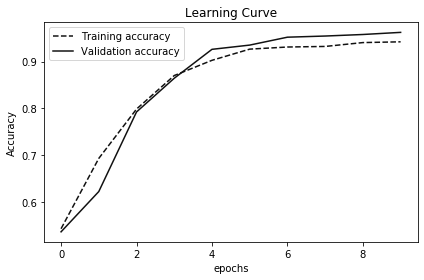

In [29]:
### data loading ###    
source_text, target_text = load_data('en.txt', 'fr.txt')

# create lookup tables
source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

# create list of sentences whose words are represented in index
source_int_text, target_int_text = text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int)

max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, target_sequence_length, max_target_sequence_length,
                                                   len(source_vocab_to_int), len(target_vocab_to_int), encoding_embedding_size, decoding_embedding_size,
                                                   rnn_size, num_layers, target_vocab_to_int)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]

valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths = next(get_batches(valid_source, valid_target, batch_size, source_vocab_to_int['<PAD>'], target_vocab_to_int['<PAD>']))                                                                                                  

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    tac = []
    vac = []

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})


            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))
        
        tac.append(train_acc)
        vac.append(valid_acc)

	# Save Model
    saver = tf.train.Saver()
    saver.save(sess, 'checkpoints/dev')
    print('Model Trained and Saved')
    save_params('checkpoints/dev')
    
### plot learning curve ###
plt.plot(tac, '--', color="#111111",  label="Training accuracy")
plt.plot(vac, color="#111111", label="Validation accuracy")

# Create plot
plt.title("Learning Curve")
plt.xlabel("epochs"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig('learning_curve.png')
plt.show()

### Inference

After finish training the model, here we test our model ability for inferencing several test sentences.

In [38]:
def sentence_to_seq(sentence, vocab_to_int):
    results = []
    for word in sentence.split(" "):
        if word in vocab_to_int:
            results.append(vocab_to_int[word])
        else:
            results.append(vocab_to_int['<UNK>'])
            
    return results
   
load_path = load_params()
loaded_graph = tf.Graph()

source_text, target_text = load_data('en.txt', 'fr.txt')

source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

input_sentence = input('English to be translated:\n')
print('\n')

with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    translate_sentence = sentence_to_seq(input_sentence, source_vocab_to_int)

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size, target_sequence_length: [len(translate_sentence)*2]*batch_size, keep_prob: 1.0})[0]

print("\nTraget Sentence:")
print('{}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))

English to be translated:
the united states is sometimes mild during june , and it is cold in september .


INFO:tensorflow:Restoring parameters from checkpoints/dev

Traget Sentence:
les états unis est parfois doux en juin et il est froid en septembre <EOS>
